In [1]:
%run C:\Users\Omar\Intern_Final_Project\notebooks\Data_Cleaning\Features_Selection.ipynb

---
### *A.<BR> Importing needed libraries*

In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRegressor,XGBRFRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from lightgbm.sklearn import LGBMRegressor
import warnings                                  
warnings.filterwarnings('ignore')

---
### *B.<BR> Data Scalling*

In [3]:
def data_scale():   
     scaler = StandardScaler()
     for col in df_red:
           if col not in ["price"]:
                  df_red[col]=scaler.fit_transform(df_red[[col]])

     for col in df_green:
           if col not in ["price"]:
                  df_green[col]=scaler.fit_transform(df_green[[col]])

     for col in df_yellow:
           if col not in ["price"]:
                  df_yellow[col]=scaler.fit_transform(df_yellow[[col]])             


data_scale()

---
### *C.<BR> Quick Comparison between multiple models with the default parameters*

#### *C.1 <BR>Creating one function to use over the three datasets*

In [4]:
def train_test(data):
    tscv = TimeSeriesSplit(n_splits=4,max_train_size=16,test_size=4,gap=0)
    mae_scores = []
    y_pred_results=[]

    models_names=["DecisionTreeRegressor","RandomForestRegressor","SVR()","LinearRegression","XGBRegressor_boo",
                  "XGBRFRegressor_boo","AdaBoostRegressor_boo","LGBMRegressor_boo","CatBoostRegressor_boo"]
              
    models=[DecisionTreeRegressor(random_state=0),RandomForestRegressor(random_state=0),SVR(),LinearRegression(),XGBRegressor(random_state=0),
        XGBRFRegressor(random_state=0),AdaBoostRegressor(random_state=0),LGBMRegressor(force_row_wise=True),CatBoostRegressor()]


    test_data=data[-20:]
    time_series_data = test_data.values

    for model in models:
              for train_index, test_index in tscv.split(time_series_data):
                                  X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                                  X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                                  model.fit(X_train, y_train)
                                  y_pred = model.predict(X_test)
                                  y_pred_results.append(y_pred)
                                  mae = np.mean(mean_absolute_error(y_test, y_pred))
                                  mae_scores.append(mae)    
                                  outcome=pd.concat([pd.DataFrame(pd.DataFrame(y_pred_results[0:4]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[4:8]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[8:12]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[12:16]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[16:20]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[20:24]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[24:28]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[28:32]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[32:36]).stack().reset_index(drop=True))],axis=1)
                                  new_date_index=pd.date_range(start="2023-07-16",end="2023-10-29",freq="W")
                                  new_date_index=pd.DataFrame({"date":new_date_index})
                                  outcome.columns=models_names
                                  outcome_all=pd.concat([outcome,new_date_index],axis=1).set_index("date")

                                  outcome_mae=pd.concat([pd.DataFrame(pd.DataFrame(mae_scores[0:4]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[4:8]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[8:12]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[12:16]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[16:20]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[20:24]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[24:28]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[28:32]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[32:36]).stack().reset_index(drop=True))],axis=1)
                                  outcome_mae.columns=models_names
                                  
                                  




    return outcome_all,outcome_mae        

#### *C.2 <BR>Applying the function on the datasets*

In [ ]:

df_red_outcomes=train_test(data=df_red)
df_green_outcomes=train_test(data=df_green)
df_yellow_outcomes=train_test(data=df_yellow)

#### *C.3 <br>Results Comparison*

#### *C.3.1<BR> Accuracy comparison condsidering mean absoulute error*

##### *C.3.1.1 <BR>df_red datata set*

In [6]:
pd.DataFrame(df_red_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score").T

,6,5,2,4,8,1,0,3,7
index,AdaBoostRegressor_boo,XGBRFRegressor_boo,SVR(),XGBRegressor_boo,CatBoostRegressor_boo,RandomForestRegressor,DecisionTreeRegressor,LinearRegression,LGBMRegressor_boo
score,2.242544,2.263427,2.390601,2.397107,2.432192,2.449592,2.579155,2.64386,2.690026


##### *C.3.1.2 <BR>df_green datata set*

In [7]:
pd.DataFrame(df_green_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score").T

,6,4,5,0,2,1,8,3,7
index,AdaBoostRegressor_boo,XGBRegressor_boo,XGBRFRegressor_boo,DecisionTreeRegressor,SVR(),RandomForestRegressor,CatBoostRegressor_boo,LinearRegression,LGBMRegressor_boo
score,1.999644,2.023283,2.027003,2.068038,2.072525,2.080522,2.092057,2.182475,2.287597


##### *C.3.1.3 <BR>df_yellow datata set*

In [8]:
pd.DataFrame(df_yellow_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score").T

,0,6,3,2,1,5,4,8,7
index,DecisionTreeRegressor,AdaBoostRegressor_boo,LinearRegression,SVR(),RandomForestRegressor,XGBRFRegressor_boo,XGBRegressor_boo,CatBoostRegressor_boo,LGBMRegressor_boo
score,2.940008,2.955728,3.079869,3.09313,3.16896,3.169931,3.181098,3.217818,3.608196


* *Results Visualization*

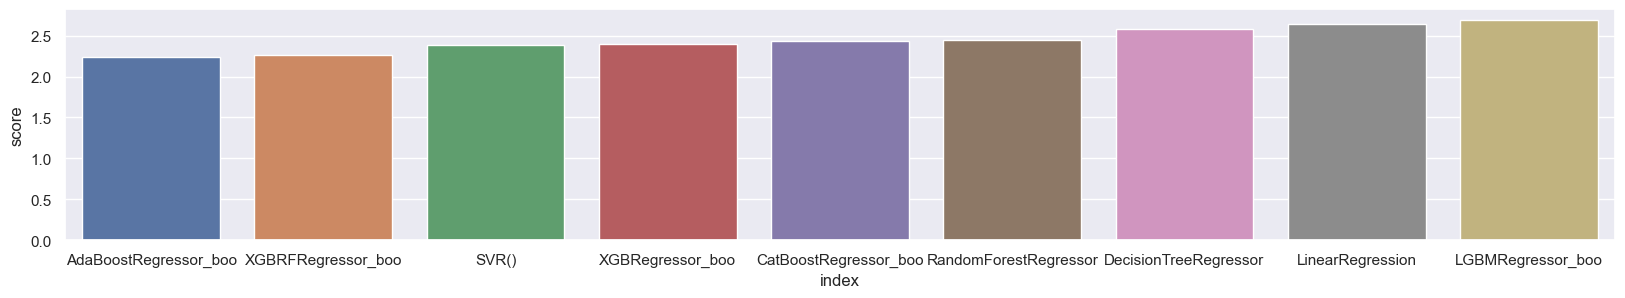

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=pd.DataFrame(df_red_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score"),x="index",y="score");

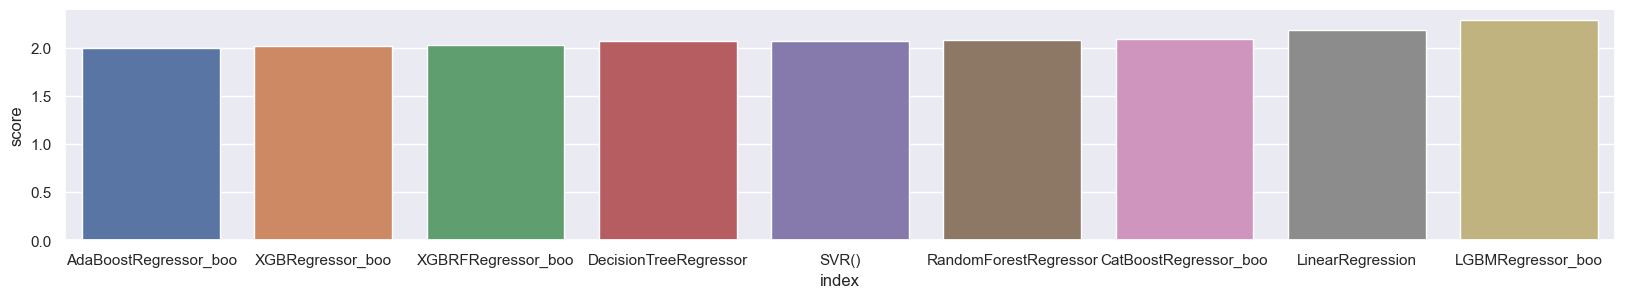

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=pd.DataFrame(df_green_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score"),x="index",y="score");

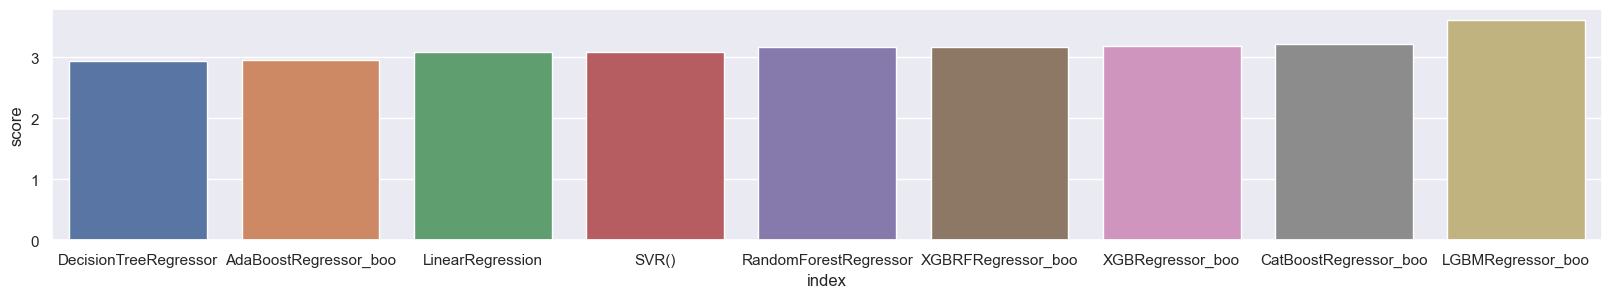

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=pd.DataFrame(df_yellow_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score"),x="index",y="score");

##### *C.3.2<BR> Outcome comparison-visualization*

##### *C.3.2.1 <BR>df_red datata set*

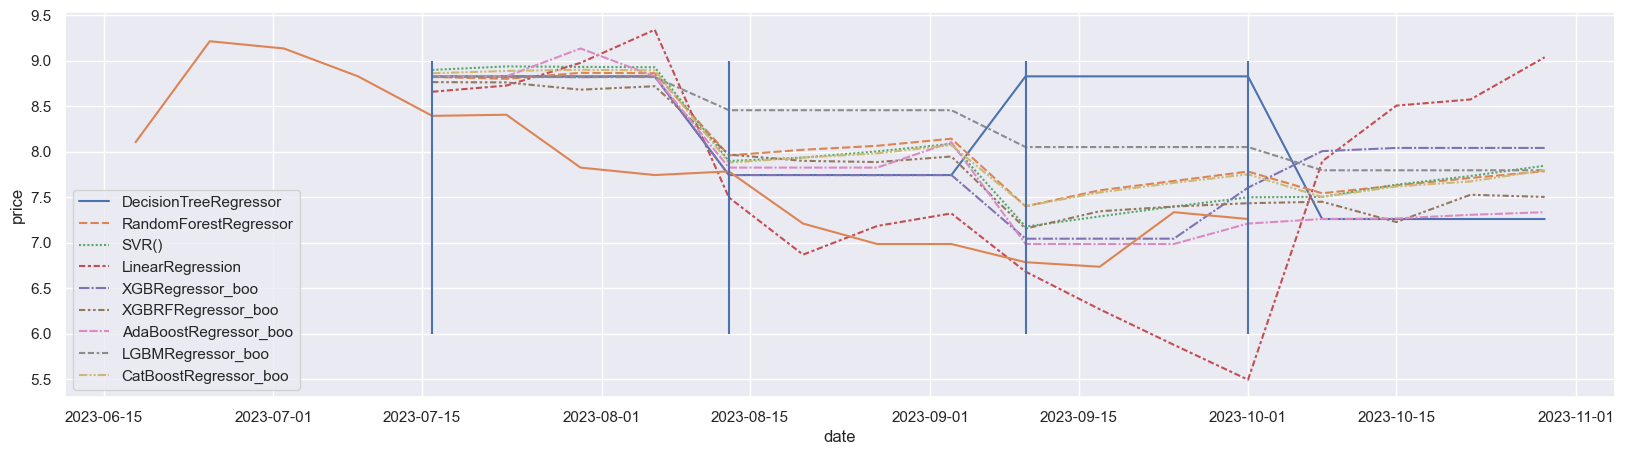

In [12]:
fig, ax = plt.subplots(figsize = (20,5));
y_min = 6
y_max = 9
sns.lineplot(df_red_outcomes[0]);
sns.lineplot(df_red[-20:-4]["price"]);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)

##### *C.3.2.2 <BR>df_green datata set*

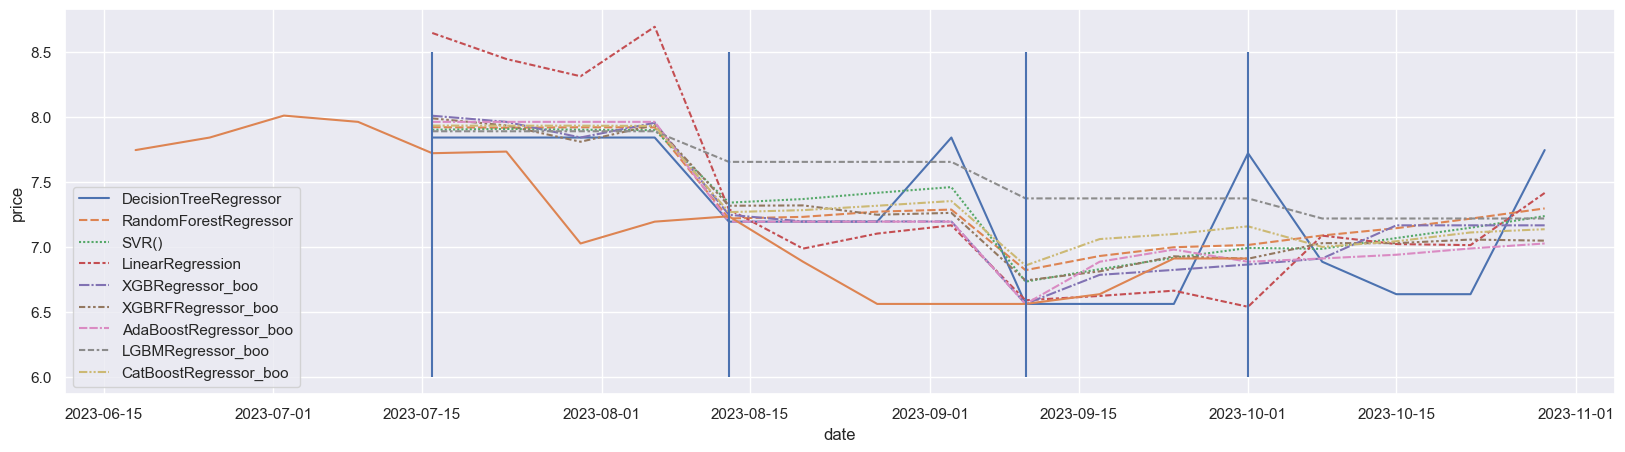

In [13]:
fig, ax = plt.subplots(figsize = (20,5));
y_min = 6
y_max = 8.5
sns.lineplot(df_green_outcomes[0]);
sns.lineplot(df_green[-20:-4]["price"]);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)

##### *C.3.2.3 <BR>df_yellow datata set*

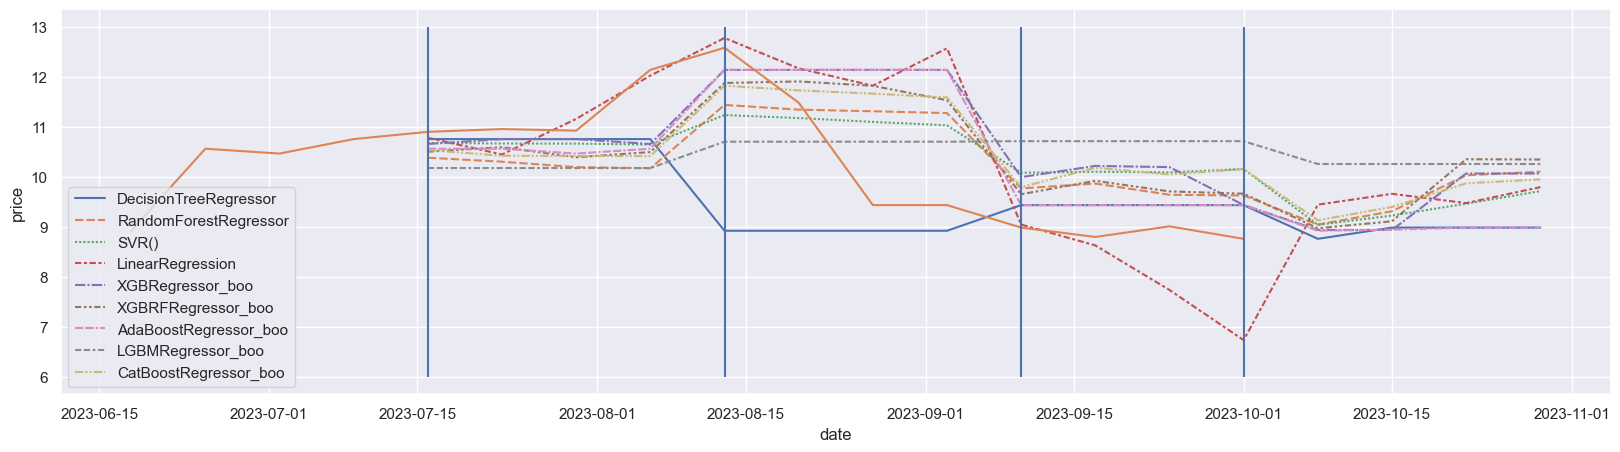

In [14]:
fig, ax = plt.subplots(figsize = (20,5));
y_min = 6 
y_max = 13
sns.lineplot(df_yellow_outcomes[0]);
sns.lineplot(df_yellow[-20:-4]["price"]);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)

---

## *Hyperparamers tunning*

In [15]:
from hyperopt import fmin,tpe,STATUS_OK,Trials,hp

In [34]:
space = {
    'max_depth': hp.quniform("max_depth", 3,10,1),
    'eta'      : hp.loguniform("eta", -5, 1),
    'gamma'    : hp.loguniform("gamma", -5, 1),
    'colsample_bytree': hp.uniform("colsample_bytree", 0.7,1),
    'subsample':hp.uniform("subsample",.7,1),
    'n_estimators': hp.quniform("n_estimators", 100,1000,1)
     }

In [39]:
def objective(space):
   tscv = TimeSeriesSplit(n_splits=4,max_train_size=16,test_size=4,gap=0)
   test_data=df_green[-20:]
   time_series_data = test_data.values
   for train_index, test_index in tscv.split(time_series_data):
                                  X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                                  X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                                  model_opt = XGBRegressor(max_depth=int(space['max_depth']),
                                                           eta=space['eta'],
                                                           gamma=space['gamma'],
                                                           colsample_bytree=space['colsample_bytree'],
                                                           subsample=space['subsample'],
                                                           n_estimators=int(space['n_estimators'])
                                                           )    
                                                             
                                  model_opt.fit(X_train,y_train)
                                  mae_scores =[]
                                  mae=mean_absolute_error(y_test,model_opt.predict(X_test))
                                  mae_scores.append(mae)
                                  mean_mae=np.mean(mae_scores)
                                  return {
                                          'loss': mean_mae,
                                          'status': STATUS_OK
                                          }
   
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100)
print(best)   

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [00:18<00:00,  5.54trial/s, best loss: 0.3081180558105472]
{'colsample_bytree': 0.8524492886021184, 'eta': 0.006845845039886065, 'gamma': 0.00960878204945349, 'max_depth': 9.0, 'n_estimators': 669.0, 'subsample': 0.975793636829041}


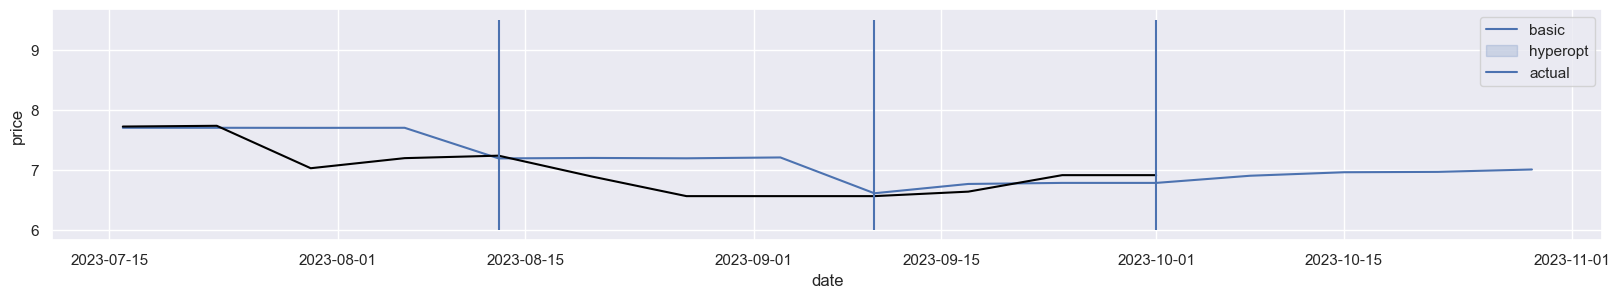

In [40]:
tscv = TimeSeriesSplit(n_splits=4,max_train_size=16,test_size=4,gap=0)
y_pred_results=[]
test_data=df_green[-20:]
time_series_data = test_data.values
for train_index, test_index in tscv.split(time_series_data):
                X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                RF_Hyop=XGBRegressor(max_depth=int(best['max_depth']),
                                     eta=float(best['eta']),
                                     gamma=float(best['gamma']),
                                     colsample_bytree=float(best['colsample_bytree']),
                                     subsample=float(best['subsample']),                                    
                                     n_estimators=int(best['n_estimators'])).fit(X_train,y_train)
                 
                y_pred = RF_Hyop.predict(X_test)
                y_pred_results.append(y_pred)
                outcome=pd.DataFrame(pd.DataFrame(y_pred_results[0:4]).stack().reset_index(drop=True))
                new_date_index=pd.date_range(start="2023-07-16",end="2023-10-29",freq="W")
                new_date_index=pd.DataFrame({"date":new_date_index})
                outcome_all=pd.concat([outcome,new_date_index],axis=1).set_index("date")
                                

fig, ax = plt.subplots(figsize = (20,3));
y_min = 6 
y_max = 9.5
#sns.lineplot(df_red_outcomes[0]['XGBRegressor_boo'],legend=True,color="red");
sns.lineplot(outcome_all,legend=True,color="blue");
sns.lineplot(df_green['price'][-16:-4],legend=True,color="black");      
plt.legend(["basic","hyperopt","actual"])       
ax.vlines(x=["2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)  
fig.show()
                   

In [72]:
space = {
    'max_depth': hp.quniform('max_depth', 2, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'max_leaf_nodes':hp.quniform('max_leaf_nodes',2,10,1)
}

In [80]:
def objective(space):
   test_data=df_green[-20:]
   time_series_data = test_data.values
   for train_index, test_index in tscv.split(time_series_data):
                                  X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                                  X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                                  model_opt = DecisionTreeRegressor(max_depth=int(space['max_depth']),
                                                                 min_samples_split=int(space['min_samples_split']),
                                                                 min_samples_leaf=int(space['min_samples_leaf']),
                                                                 max_leaf_nodes=int(space['max_leaf_nodes'])
                                                                 )  
                                  
                                  model_opt.fit(X_train,y_train)
                                  mae_scores =[]
                                  mae=mean_absolute_error(y_test,model_opt.predict(X_test))
                                  mae_scores.append(mae)
                                  mean_mae=np.mean(mae_scores)
                                  return {
                                          'loss': mean_mae,
                                          'status': STATUS_OK
                                          }

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100)
print(best)              

100%|██████████| 100/100 [00:02<00:00, 46.95trial/s, best loss: 0.3745367875000003]
{'max_depth': 20.0, 'max_leaf_nodes': 6.0, 'min_samples_leaf': 1.0, 'min_samples_split': 4.0}


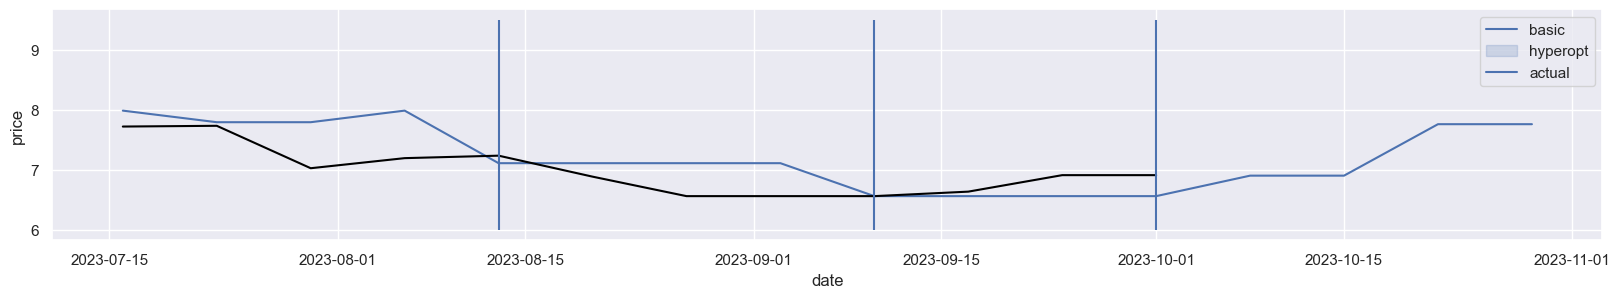

In [81]:
tscv = TimeSeriesSplit(n_splits=4,max_train_size=16,test_size=4,gap=0)
y_pred_results=[]
test_data=df_green[-20:]
time_series_data = test_data.values
for train_index, test_index in tscv.split(time_series_data):
                X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                RF_Hyop=DecisionTreeRegressor(max_depth=int(best['max_depth']),
                                                                 min_samples_split=int(best['min_samples_split']),
                                                                 min_samples_leaf=int(best['min_samples_leaf']),
                                                                 max_leaf_nodes=int(best['max_leaf_nodes'])).fit(X_train,y_train)
                 
                y_pred = RF_Hyop.predict(X_test)
                y_pred_results.append(y_pred)
                outcome=pd.DataFrame(pd.DataFrame(y_pred_results[0:4]).stack().reset_index(drop=True))
                new_date_index=pd.date_range(start="2023-07-16",end="2023-10-29",freq="W")
                new_date_index=pd.DataFrame({"date":new_date_index})
                outcome_all=pd.concat([outcome,new_date_index],axis=1).set_index("date")
                                

fig, ax = plt.subplots(figsize = (20,3));
y_min = 6 
y_max = 9.5
#sns.lineplot(df_red_outcomes[0]['XGBRegressor_boo'],legend=True,color="red");
sns.lineplot(outcome_all,legend=True,color="blue");
sns.lineplot(df_green['price'][-16:-4],legend=True,color="black");      
plt.legend(["basic","hyperopt","actual"])       
ax.vlines(x=["2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)  
fig.show()
                   

In [82]:
space = {
    'n_estimators':hp.quniform('n_estimators',50,100,1),
    'learning_rate':hp.loguniform("learning_rate",-5,1)
}

In [91]:
def objective(space):
   test_data=df_red[-20:]
   time_series_data = test_data.values
   for train_index, test_index in tscv.split(time_series_data):
                                  X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                                  X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                                  model_opt = AdaBoostRegressor(
                                                                n_estimators=int(space['n_estimators']),
                                                                learning_rate=space['learning_rate'])
                                  

                                  model_opt.fit(X_train,y_train)
                                  mae_scores =[]
                                  mae=mean_absolute_error(y_test,model_opt.predict(X_test))
                                  mae_scores.append(mae)
                                  mean_mae=np.mean(mae_scores)
                                  return {
                                          'loss': mean_mae,
                                          'status': STATUS_OK
                                          }
              
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100)
print(best)           

100%|██████████| 100/100 [00:04<00:00, 24.71trial/s, best loss: 0.30783278749999976]
{'learning_rate': 0.016033935715247825, 'n_estimators': 64.0}


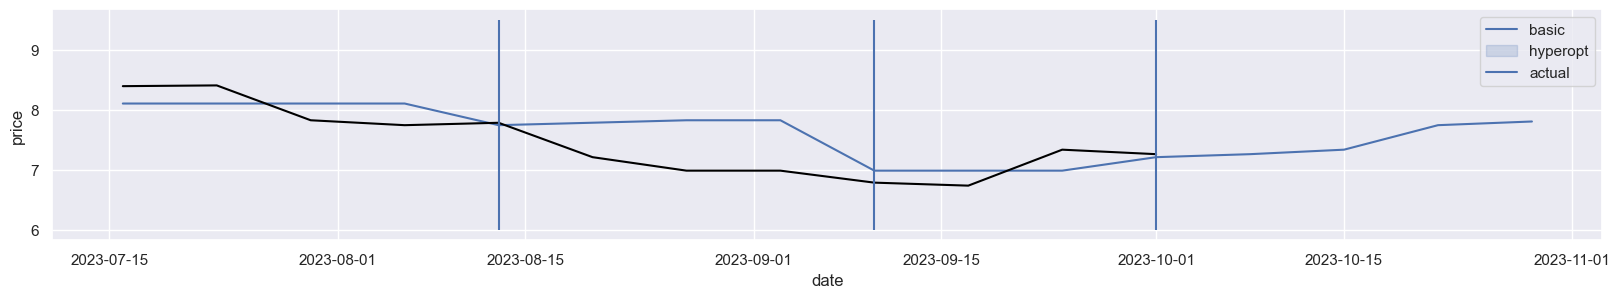

In [92]:
tscv = TimeSeriesSplit(n_splits=4,max_train_size=16,test_size=4,gap=0)
y_pred_results=[]
test_data=df_red[-20:]
time_series_data = test_data.values
for train_index, test_index in tscv.split(time_series_data):
                X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                RF_Hyop=AdaBoostRegressor(
                                          n_estimators=int(best['n_estimators']),
                                          learning_rate=best['learning_rate'])
                 
                RF_Hyop.fit(X_train,y_train)
                y_pred = RF_Hyop.predict(X_test)
                y_pred_results.append(y_pred)
                outcome=pd.DataFrame(pd.DataFrame(y_pred_results[0:4]).stack().reset_index(drop=True))
                new_date_index=pd.date_range(start="2023-07-16",end="2023-10-29",freq="W")
                new_date_index=pd.DataFrame({"date":new_date_index})
                outcome_all=pd.concat([outcome,new_date_index],axis=1).set_index("date")
                                

fig, ax = plt.subplots(figsize = (20,3));
y_min = 6 
y_max = 9.5
#sns.lineplot(df_red_outcomes[0]['XGBRegressor_boo'],legend=True,color="red");
sns.lineplot(outcome_all,legend=True,color="blue");
sns.lineplot(df_red['price'][-16:-4],legend=True,color="black");      
plt.legend(["basic","hyperopt","actual"])       
ax.vlines(x=["2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)  
fig.show()
                   